# Assignment 3
## Problem statement (Feature Engineering: Concrete Strength Prediction)

### Goal

Using the data available in file concrete_data.xls. Apply feature engineering methods to obtain 85% to 95% accuracy  (tolerance limit 95% of the time (confidence level).

#### Resources Available

The data for this project is available in file 
https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/


### Variable Information:

Given is the variable name, variable type, the measurement unit and a brief description. 
The concrete compressive strength is the regression problem. The order of this listing 
corresponds to the order of numerals along the rows of the database. 

#### Name -- Data Type -- Measurement -- Description

- Cement (component 1) -- quantitative -- kg in a m3 mixture -- Input Variable
- Blast Furnace Slag (component 2) -- quantitative -- kg in a m3 mixture -- Input Variable
- Fly Ash (component 3) -- quantitative -- kg in a m3 mixture -- Input Variable
- Water (component 4) -- quantitative -- kg in a m3 mixture -- Input Variable
- Superplasticizer (component 5) -- quantitative -- kg in a m3 mixture -- Input Variable
- Coarse Aggregate (component 6) -- quantitative -- kg in a m3 mixture -- Input Variable
- Fine Aggregate (component 7) -- quantitative -- kg in a m3 mixture -- Input Variable
- Age -- quantitative -- Day (1~365) -- Input Variable
- **Concrete compressive strength -- quantitative -- MPa -- Output Variable**

In [25]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import itertools
import seaborn as sns

import scipy.stats as st

from sklearn.model_selection import train_test_split 


from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample

from pprint import pprint
from time import time
import warnings 
warnings.filterwarnings('ignore')

df = pd.read_csv ("concrete.csv")

print('--df.info()--')
print(df.info())
print("  ")
print('--df.columns--')
print(df.columns)

--df.info()--
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement          1030 non-null float64
slag            1030 non-null float64
ash             1030 non-null float64
water           1030 non-null float64
superplastic    1030 non-null float64
coarseagg       1030 non-null float64
fineagg         1030 non-null float64
age             1030 non-null int64
strength        1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB
None
  
--df.columns--
Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age', 'strength'],
      dtype='object')


In [26]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [27]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


In [28]:
df.apply(lambda x: sum(x.isnull()))

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

- No missing data found

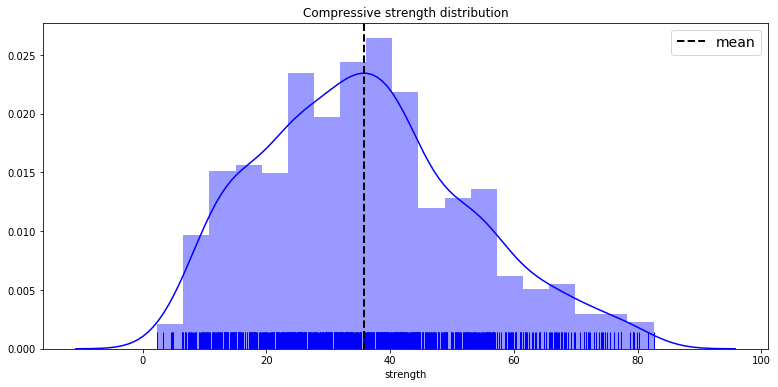

In [29]:
plt.figure(figsize=(13,6))
sns.distplot(df["strength"],color="b",rug=True)
plt.axvline(df["strength"].mean(),
            linestyle="dashed",color="k",
            label='mean',linewidth=2)
plt.legend(loc="best",prop={"size":14})
plt.title("Compressive strength distribution")
plt.show()

- The Compressive Streng is normal distributed

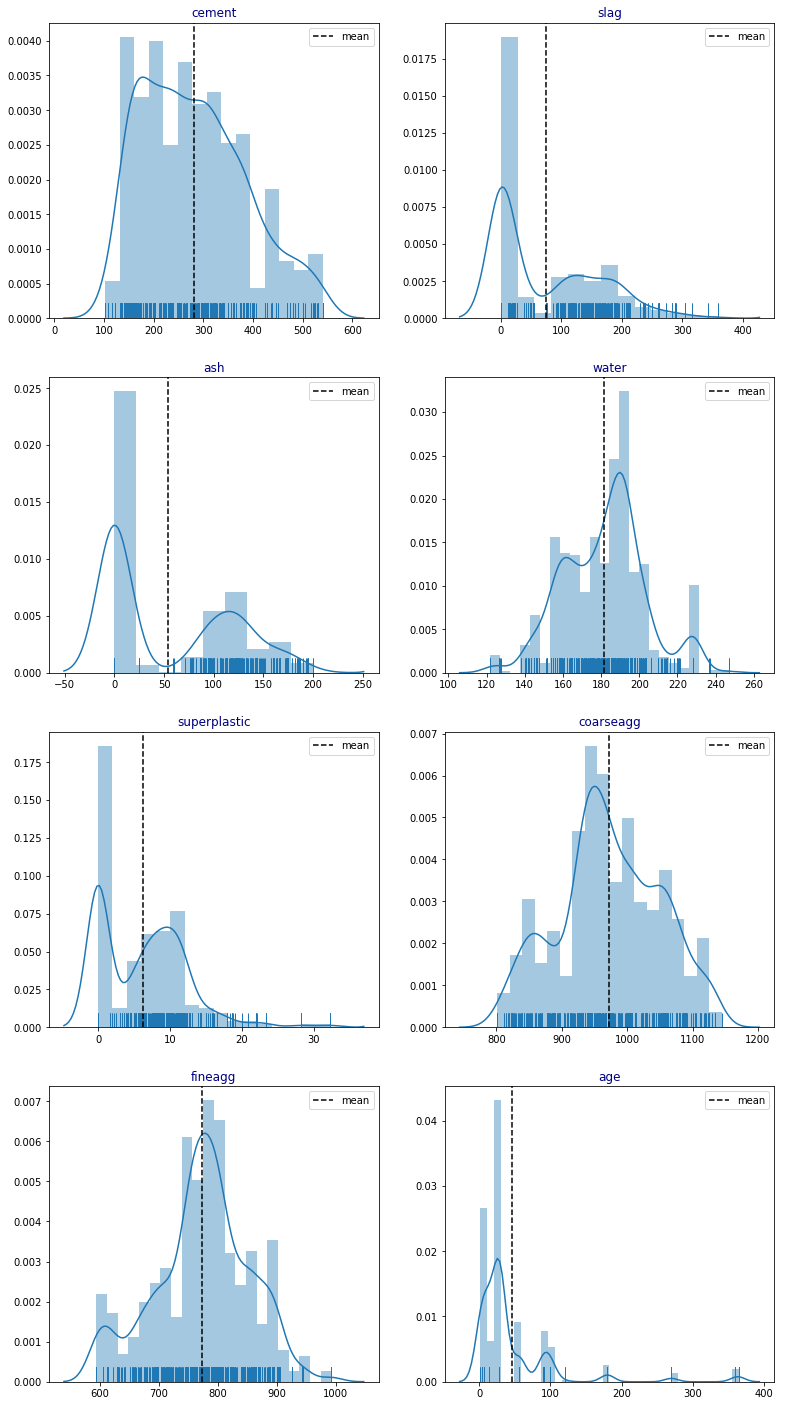

In [30]:
cols = [i for i in df.columns if i not in 'strength']
length = len(cols)
cs = ["b","r","g","c","m","k","lime","c"]
fig = plt.figure(figsize=(13,25))

for i,j,k in itertools.zip_longest(cols,range(length),cs):
    plt.subplot(4,2,j+1)
    ax = sns.distplot(df[i],rug=True)
    ax.set_facecolor("w")
    plt.axvline(df[i].mean(),linestyle="dashed",label="mean",color="k")
    plt.legend(loc="best")
    plt.title(i,color="navy")
    plt.xlabel("")

- Several features are skew to the left of the distribution (slag, ash, superplastic and age)

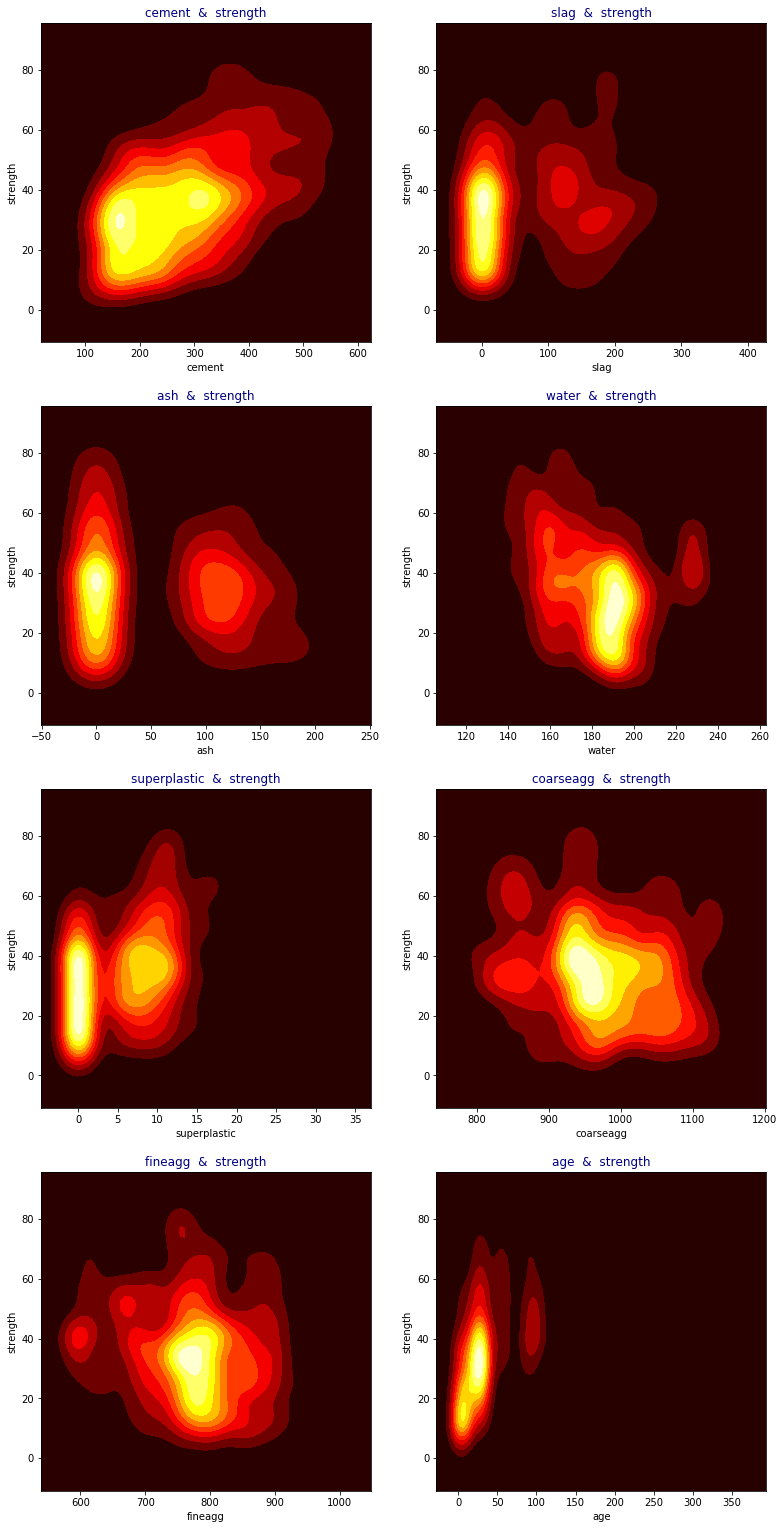

In [31]:
cols = [i for i in df.columns if i not in 'strength']
length = len(cols)

plt.figure(figsize=(13,27))
for i,j in itertools.zip_longest(cols,range(length)):
    plt.subplot(4,2,j+1)
    sns.kdeplot(df[i],
                df["strength"],
                cmap="hot",
                shade=True)
    plt.title(i+"  &  strength",color="navy")

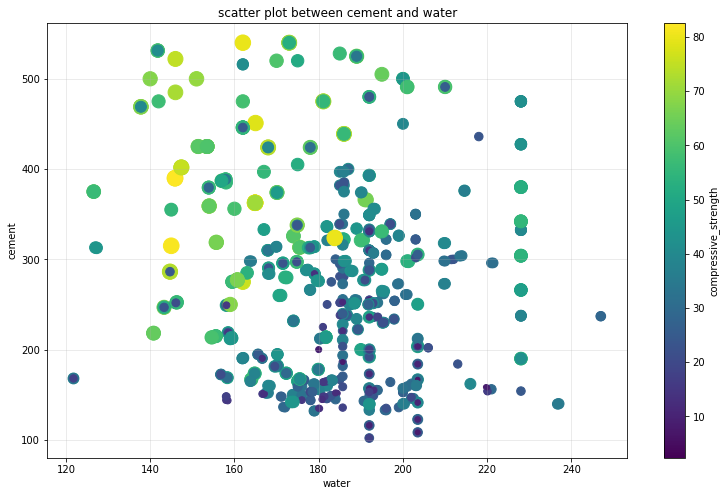

In [32]:
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(111)
plt.scatter(df["water"],df["cement"],
            c=df["strength"],s=df["strength"]*3,
            linewidth=1)
ax.set_facecolor("w")
ax.set_xlabel("water")
ax.set_ylabel("cement")
lab = plt.colorbar()
lab.set_label("compressive_strength")
plt.title("scatter plot between cement and water")
plt.grid(True,alpha=.3)
plt.show()

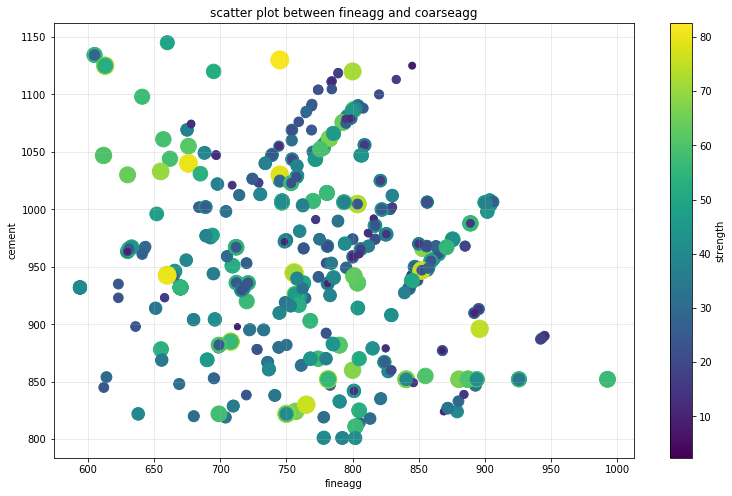

In [33]:
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(111)
plt.scatter(df["fineagg"],df["coarseagg"],
            c=df["strength"],s=df["strength"]*4,
            linewidth=1)
ax.set_facecolor("w")
ax.set_xlabel("fineagg")
ax.set_ylabel("cement")
lab = plt.colorbar()
lab.set_label("strength")
plt.title("scatter plot between fineagg and coarseagg")
plt.grid(True,alpha=.3)
plt.show()

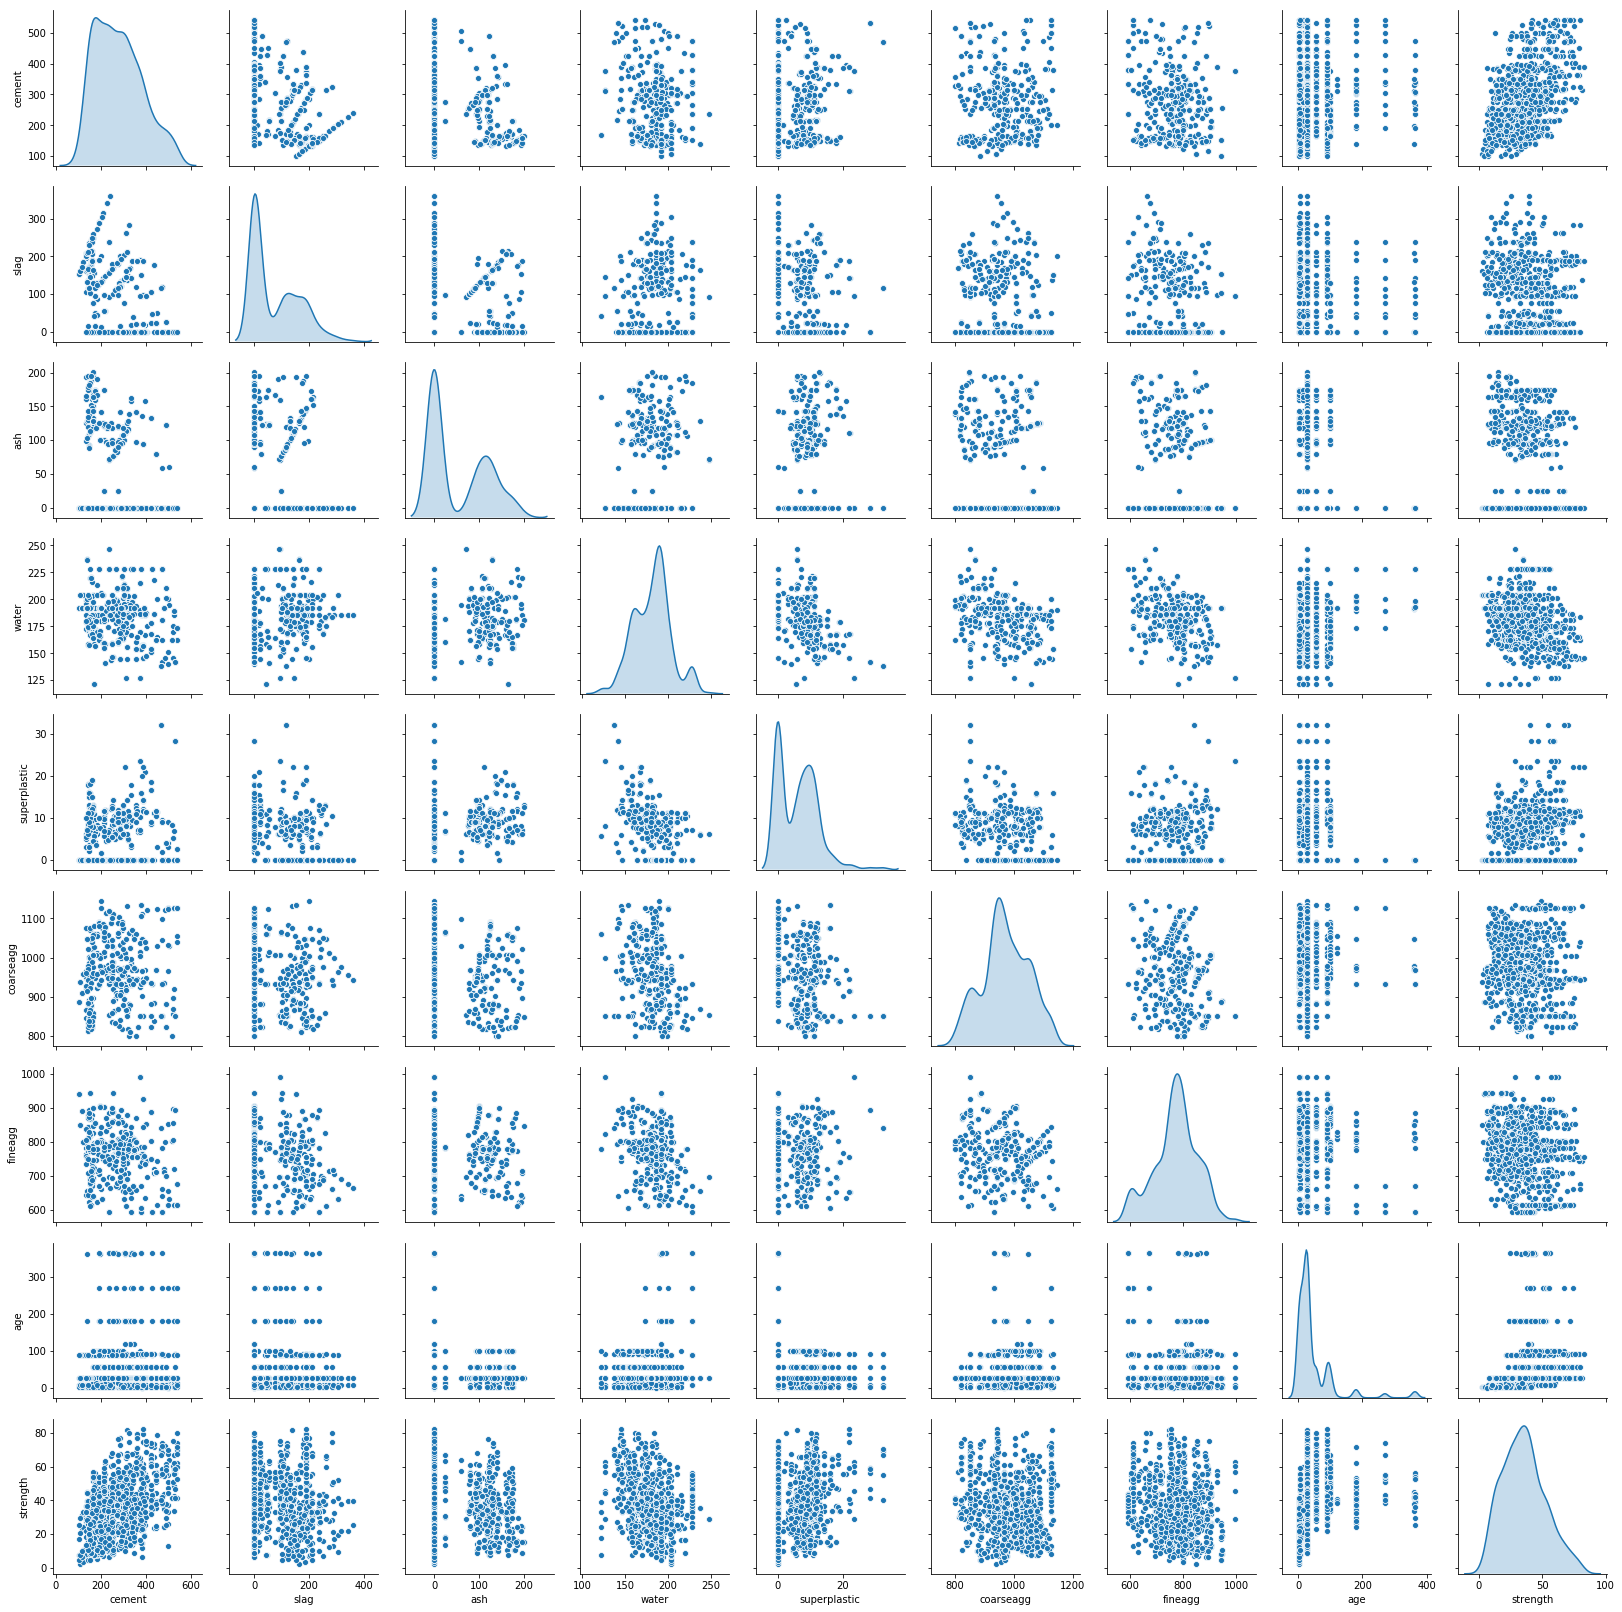

In [36]:
sns.pairplot(df, diag_kind="kde")
plt.show()

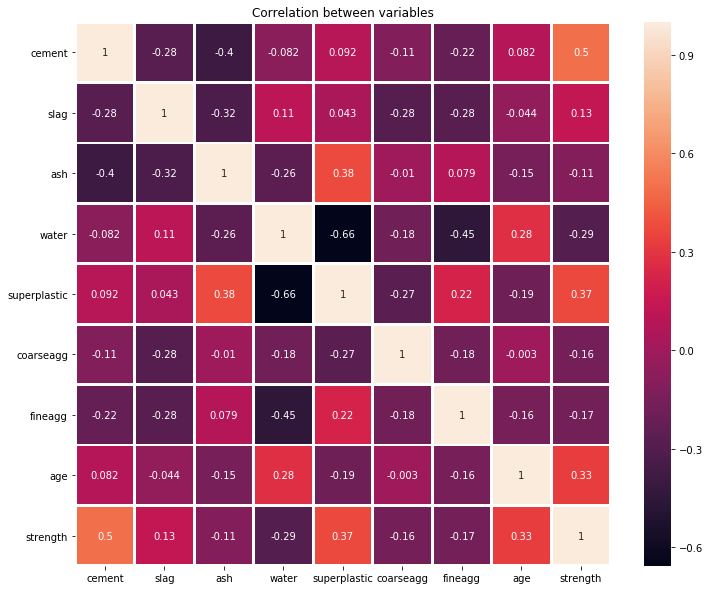

In [37]:
cor = df.corr()

plt.figure(figsize=(12,10))

sns.heatmap(cor,annot=True,linewidth=2)
plt.title("Correlation between variables")
plt.show()

- **cement, water, age and superplastic** are highly correlated to **strength**
- **superplastic and ash** are highly correlated
- **age and water** both are highly correlated

## Data Cleaning

### Identify the outlier
#### By using inter quarter range (IQR) method to detect and remove the outlier
Using IQR method is better than z-score approach, because most of the concrete data is skewed to left as show in the plots.


In [38]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df_out.shape

(941, 9)

## Spliting Data

### Split By ratio of 70:30

In [39]:
X_train, X_test, y_train, y_test = train_test_split( df_out.loc[:, df_out.columns != 'strength'], df_out["strength"], test_size=0.3, random_state = 0) 

## Modelling
### Modelling with Pipeline and GridSearchCV

### Preprocessing Pipeline
#### ColumnTransformer for Numeric Transformer and Categorical Transformer

- In this case study, no categorical features
- All the numeric features will be transformed by the scaler of QuantileTransformer().

In [40]:
numeric_features = [i for i in df_out.columns if i not in 'strength']
numeric_transformer = Pipeline(steps=[
    ('scaler',  QuantileTransformer())])

categorical_features = []
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

## Modelling

### Preparing the pipeline that streamline the whole process from preprocessing to testing the model

1. Preprocessor is pre-defined as aboved, which is **QuantileTransformer()**
2. To improve the model by reducing the dimension, two strategy, **PCA() and SelectKBest(f_regression)** will be decided
3. Regressor will also be decided from **Ridge(), Lasso(), RandomForestRegressor(), GradientBoostingRegressor(), ExtraTreesRegressor(), and DecisionTreeRegressor())**.
5. All the **hyperparameter ranges** also is defined.
6. All the above step will be streamlined by **pipeline**.
7. **GridSearchCV** is used to choose the best estimator amongst all the combination.

### Evaluation for the scoring
1. **"neg_means_square_error"** is chosen for this case. Higher number of "neg_means_square_error" is better, or can be interpreted as value nearer to 0 is better.


In [41]:

class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

# Create a pipeline
pipe = Pipeline([('preprocessor', preprocessor),
                 ('reduce_dim', PCA()),
                 ('regressor', DummyEstimator())]) # Placeholder Estimator

#prepareing for the hyperparemeter to be tuned
n_features_to_test = np.arange(1, 9)
alpha_to_test = 2.0**np.arange(-6, +6)
linear_regressor = [Ridge(), 
                    Lasso()]

ensemble_regressor = [RandomForestRegressor(bootstrap=True, oob_score=True, n_jobs=-1),
                      GradientBoostingRegressor(), 
                      ExtraTreesRegressor(bootstrap=True, oob_score =True, n_jobs=-1)]

tree_regressor = [DecisionTreeRegressor(),
                  ExtraTreeRegressor() ]

params = [
        {'reduce_dim': [PCA()],
         'reduce_dim__n_components': n_features_to_test,
         'regressor': linear_regressor,
         'regressor__alpha': alpha_to_test,
         "regressor__random_state" : [1]},
    
        {'reduce_dim': [PCA()],
         'reduce_dim__n_components': n_features_to_test,
         "regressor": ensemble_regressor,
         "regressor__random_state" : [1],
         "regressor__n_estimators" : [10,50,100],
         "regressor__max_depth": [3, 5, 10, None],   
         "regressor__min_samples_split": [2, 5, 10, 15]},
    
        {'reduce_dim': [PCA()],
         'reduce_dim__n_components': n_features_to_test,
         "regressor": tree_regressor,
         "regressor__random_state" : [1],
         "regressor__max_depth": [3, 5, 10, None],   
         "regressor__min_samples_split": [2, 5, 10, 15]},
    
        {'reduce_dim': [SelectKBest(f_regression)],
         'reduce_dim__k': n_features_to_test,
         'regressor': linear_regressor,
         'regressor__alpha': alpha_to_test,
         "regressor__random_state" : [1]},
    
        {'reduce_dim': [SelectKBest(f_regression)],
         'reduce_dim__k': n_features_to_test,
         "regressor": ensemble_regressor,
         "regressor__random_state" : [1],
         "regressor__n_estimators" : [10,50,100],
         "regressor__max_depth": [3, 5, 10, None],   
         "regressor__min_samples_split": [2, 5, 10, 15]},
    
        {'reduce_dim': [SelectKBest(f_regression)],
         'reduce_dim__k': n_features_to_test,
         "regressor": tree_regressor,
         "regressor__random_state" : [1],
         "regressor__max_depth": [3, 5, 10, None],   
         "regressor__min_samples_split": [2, 5, 10, 15]}
    
        ]


gridsearch = GridSearchCV(pipe, params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)

print("pipeline:", [name for name, _ in pipe.steps])
print("parameters:")
pprint(params)
t0 = time()
gridsearch.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()
print('Negative MSE score is: ', gridsearch.score(X_test, y_test))


pipeline: ['preprocessor', 'reduce_dim', 'regressor']
parameters:
[{'reduce_dim': [PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)],
  'reduce_dim__n_components': array([1, 2, 3, 4, 5, 6, 7, 8]),
  'regressor': [Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
                Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)],
  'regressor__alpha': array([1.5625e-02, 3.1250e-02, 6.2500e-02, 1.2500e-01, 2.5000e-01,
       5.0000e-01, 1.0000e+00, 2.0000e+00, 4.0000e+00, 8.0000e+00,
       1.6000e+01, 3.2000e+01]),
  'regressor__random_state': [1]},
 {'reduce_dim': [PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)],
  'reduce_dim

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 835 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 1325 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 1770 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2297 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2904 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 3593 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4362 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5213 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 6144 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 7487 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 9418 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 10593 tasks      |

done in 759.002s

Negative MSE score is:  -24.77230601825275


In [42]:
gridsearch.best_params_

{'reduce_dim': SelectKBest(k=8, score_func=<function f_regression at 0x00000220832B07B8>),
 'reduce_dim__k': 8,
 'regressor': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=10, min_weight_fraction_leaf=0.0,
              n_estimators=100, n_iter_no_change=None, presort='auto',
              random_state=1, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False),
 'regressor__max_depth': 5,
 'regressor__min_samples_split': 10,
 'regressor__n_estimators': 100,
 'regressor__random_state': 1}

Text(0.5, 1.0, 'FEATURE IMPORTANCES')

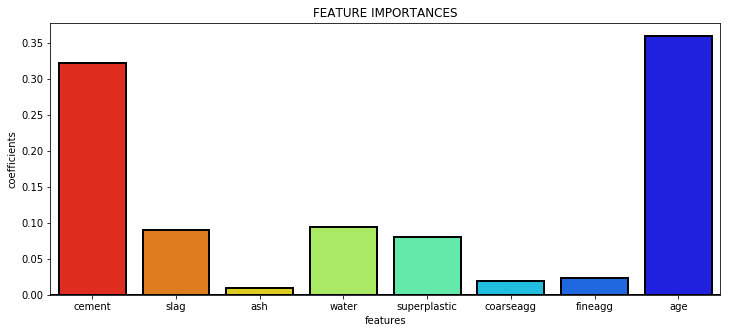

In [43]:
plt.figure(figsize=(12,5))
coef = pd.DataFrame(gridsearch.best_estimator_.named_steps['regressor'].feature_importances_)
coef["feat"] = X_train.columns
ax2 = sns.barplot(coef["feat"],coef[0],palette="jet_r",
                  linewidth=2,edgecolor="k"*coef["feat"].nunique())

ax2.axhline(0,color="k",linewidth=2)
plt.ylabel("coefficients")
plt.xlabel("features")
plt.title('FEATURE IMPORTANCES')

- The features importance show similarity to the correlation chart

In [44]:
predict = gridsearch.best_estimator_.predict(X_test)

print ("RMSE:", np.sqrt(mean_squared_error(y_test,predict)) )
print ("R2 Score",r2_score(y_test,predict))
prediction = pd.DataFrame(predict)
cross_val = cross_val_score(gridsearch.best_estimator_ ,X_train,y_train,cv=5,scoring="neg_mean_squared_error")
cross_val = cross_val.ravel()

cv_mean = cross_val.mean()
cv_std = cross_val.std()

cv_rmse_mean = cv_mean
cv_rmse_std = cv_std
print ("cv-mean :", cv_rmse_mean)
print ("cv-std  :", cv_rmse_std)


RMSE: 4.9771785198295575
R2 Score 0.9114174585277182
cv-mean : -24.80080040602669
cv-std  : 6.109235990863117


Text(0, 0.5, 'values')

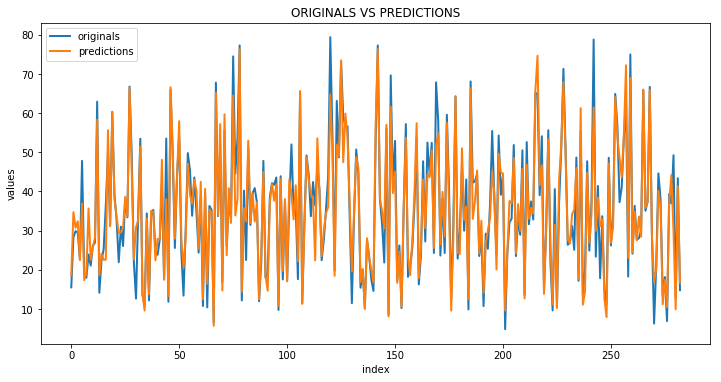

In [45]:
plt.figure(figsize=(13,28))
plt.subplot(211)

testy = y_test.reset_index()["strength"]

ax = testy.plot(label="originals",figsize=(12,13),linewidth=2)
ax = prediction[0].plot(label = "predictions",figsize=(12,13),linewidth=2)
plt.legend(loc="best")
plt.title("ORIGINALS VS PREDICTIONS")
plt.xlabel("index")
plt.ylabel("values")


- The predicted value is following the original value

In [46]:
gridsearch.best_estimator_.named_steps['regressor']

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=10, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=1, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

## Confidance Interval for the Model

### By using bootstrap and resample method to test the model


In [47]:
# configure bootstrap
n_iterations = 1000              # Number of bootstrap samples to create

# run bootstrap
RMSEstats = list()
R2stats = list()
for i in range(n_iterations):
    # prepare train and test sets
    df_resample = resample(df_out)  # Sampling with replacement 
    X_train, X_test, y_train, y_test = train_test_split( df_resample.loc[:, df_resample.columns != 'strength'], 
                                                         df_resample["strength"], 
                                                         test_size=0.5, 
                                                         random_state = 0) 
    # fit model
    model = gridsearch.best_estimator_.named_steps['regressor']
    model.fit(X_train, y_train)
    # evaluate model
    predictions = model.predict(X_test)
    RMSE_score = np.sqrt(mean_squared_error(y_test, predictions))   
    R2_score = r2_score(y_test, predictions)  
    RMSEstats.append(RMSE_score)
    R2stats.append(R2_score)

### The distribution of the $R^2$ score of the model 

R2 score mean is 0.92 (+/- 0.026) with 95% confidence interval


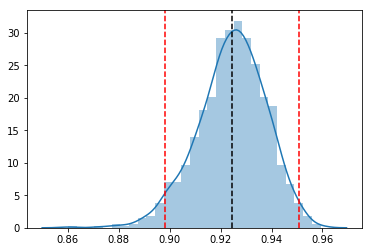

In [48]:

upper = np.mean(R2stats)+1.96*np.std(R2stats)
lower = np.mean(R2stats)-1.96*np.std(R2stats)
print('R2 score mean is %.2f (+/- %.3f) with 95%% confidence interval' % (np.mean(R2stats),1.96*np.std(R2stats)))

sns.distplot(R2stats)
plt.axvline(np.mean(R2stats),linestyle="dashed",color="k")
plt.axvline(lower,linestyle="dashed",color="r")
plt.axvline(upper,linestyle="dashed",color="r")

### The distribution of the RMSE of the model 

RMSE score mean is 4.52 (+/- 0.752) with 95% confidence interval


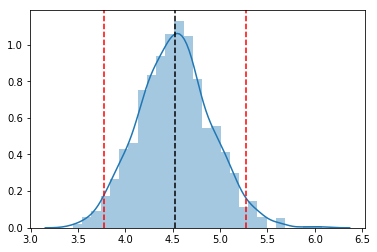

In [49]:
upper = np.mean(RMSEstats)+1.96*np.std(RMSEstats)
lower = np.mean(RMSEstats)-1.96*np.std(RMSEstats)
print('RMSE score mean is %.2f (+/- %.3f) with 95%% confidence interval' % (np.mean(RMSEstats),1.96*np.std(RMSEstats)))

sns.distplot(RMSEstats)
plt.axvline(np.mean(RMSEstats),linestyle="dashed",color="k")
plt.axvline(lower,linestyle="dashed",color="r")
plt.axvline(upper,linestyle="dashed",color="r")

## Conclusion
- __GradientBoostingRegressor__ has been __selected__ with __tuned hyperparameter__ from GridSearchCV
- By __bootstraping and resample__, the performance of the model is measured.
- It has __lowest__ the __Root Means Square Error__, where
  - __RMSE = 4.52 (+/- 0.752)__ 
  - __R2_score = 0.92 (+/- 0.026)__ 

__GradientBoostingRegressor__ performed better. It is a type of inductively generated tree ensemble model. __At each step, a new tree is trained against the negative gradient of the loss function__, which is analogous to (or identical to, in the case of least-squares error) the residual error.

__RMSE__ is the __square root of the variance of the residuals__ and it is a better measure of how accurately the model predicts the response compare to R2 score. This is because __RMSE is an absolute measure of fit__ whereas __R2 is a relative measure of fit__. 